# ML Practical 3 - Convolutional Neural Networks in TensorFlow - Samuel Clarke 2346337

In [1]:
%matplotlib notebook

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import numpy as np
import itertools

### Initialisations

Let us write some helper functions to initialise weights and biases. We'll initialise weights as Gaussian random variables with mean 0 and variance 0.0025. For biases we'll initialise everything with a constant 0.1. This is because we're mainly going to be using ReLU non-linearities.

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### Model

Let's define the model. The model is defined as follows:

* An input that is 728 dimensional vector. 
* Reshape the input as 28x28x1 images (only 1 because they are grey scale) 
* A convolutional layer with 25 filters of shape 12x12x1 and a ReLU non-linearity (with stride (2, 2) and no padding)
* A convolutional layer with 64 filters of shape 5x5x25 and a ReLU non-linearity (with stride (1, 1) and padding to maintain size)
* A max_pooling layer of shape 2x2
* A fully connected layer taking all the outputs of the max_pooling layer to 1024 units and ReLU nonlinearity
* A fully connected layer taking 1024 units to 10 no activation function (the softmax non-linearity will be included in the loss function rather than in the model)

In [3]:
x = tf.placeholder(tf.float32, shape=[None, 784])
x_ = tf.reshape(x, [-1, 28, 28, 1]) # -1 is a placeholder, allows variable batch size
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Define the first convolution layer here
W_conv1 = weight_variable([12, 12, 1, 25])
b_conv1 = bias_variable([25])
convolution_stage1 = tf.nn.conv2d(x_, W_conv1, strides=[1,2,2,1], padding='VALID') + b_conv1
h_conv1 = tf.nn.relu(convolution_stage1)

# Define the second convolution layer here
W_conv2 = weight_variable([5, 5, 25, 64])
b_conv2 = bias_variable([64])
convolution_stage2 = tf.nn.conv2d(h_conv1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2 # inconsistency between pdf and jupyter skeleton for 2nd stide length here
h_conv2 = tf.nn.relu(convolution_stage2)

# Define maxpooling
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME') # max pooling over 2x2 blocks

# All subsequent layers will be fully connected ignoring geometry so we'll flatten the layer
# Flatten the h_pool2_layer (as it has a multidimensional shape) 
h_pool2_flat = tf.reshape(h_pool2, [-1, 5*5*64]) # ceil((28-11)/2) -> SAME, stride 1 -> 2x2 max-pooling w stride 2 and SAME padding

# Define the first fully connected layer here
W_fc1 = weight_variable([5*5*64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Use dropout for this layer (should you wish)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# The final fully connected layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#### Loss Function, Accuracy and Training Algorithm

* We'll use the cross entropy loss function. The loss function is called `tf.nn.cross_entropy_with_logits` in tensorflow

* Accuray is simply defined as the fraction of data correctly classified

* For training you should use the AdamOptimizer (read the documentation) and set the learning rate to be 1e-4. You are welcome, and in fact encouraged, to experiment with other optimisation procedures and learning rates. 

* (Optional): You may even want to use different filter sizes once you are finished with experimenting with what is asked in this practial

In [4]:
# We'll use the cross entropy loss function 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))

# And classification accuracy
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# And the Adam optimiser
train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)

In [5]:
# Load the mnist data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


<IPython.core.display.Javascript object>


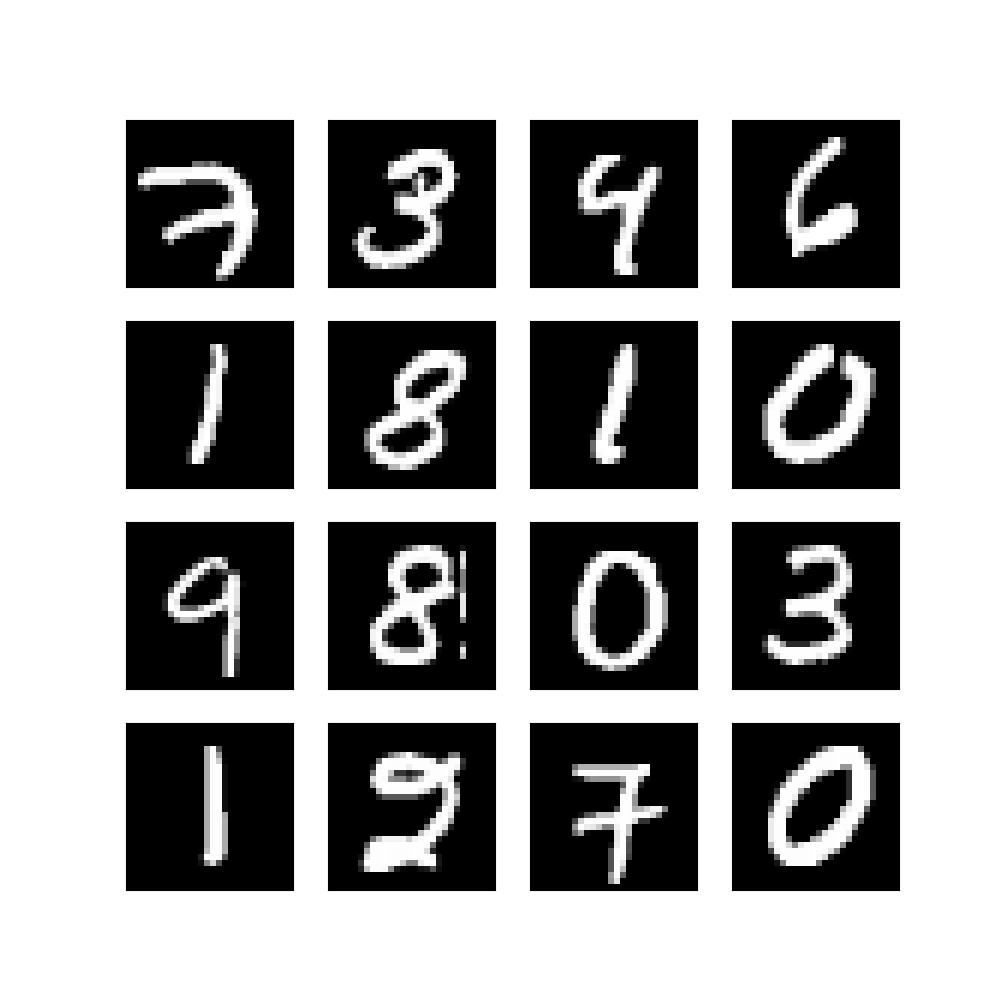

In [6]:
# Let us visualise the first 16 data points from the MNIST training data

fig = plt.figure()
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(mnist.train.images[i].reshape(28, 28), cmap='Greys_r')  

In [7]:
# Start a tf session and run the optimisation algorithm
sess = tf.Session()

sess.run(tf.global_variables_initializer())
for i in range(5001):
    batch_xs, batch_ys = mnist.train.next_batch(50)
    if i % 100 == 0:
        train_accuracy = accuracy.eval(session=sess, feed_dict={
                x: batch_xs, y_: batch_ys, keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(session=sess, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

step 0, training accuracy 0.1
step 100, training accuracy 0.78
step 200, training accuracy 0.86
step 300, training accuracy 0.92
step 400, training accuracy 0.88
step 500, training accuracy 0.96
step 600, training accuracy 0.92
step 700, training accuracy 0.94
step 800, training accuracy 0.98
step 900, training accuracy 0.96
step 1000, training accuracy 0.9
step 1100, training accuracy 0.94
step 1200, training accuracy 0.96
step 1300, training accuracy 0.96
step 1400, training accuracy 1
step 1500, training accuracy 0.98
step 1600, training accuracy 0.94
step 1700, training accuracy 0.98
step 1800, training accuracy 1
step 1900, training accuracy 0.92
step 2000, training accuracy 0.96
step 2100, training accuracy 1
step 2200, training accuracy 0.98
step 2300, training accuracy 1
step 2400, training accuracy 0.98
step 2500, training accuracy 1
step 2600, training accuracy 0.98
step 2700, training accuracy 0.98
step 2800, training accuracy 0.96
step 2900, training accuracy 0.96
step 3000

In [8]:
# Print accuracy on the test set
print('Test accuracy: %g' % sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Test accuracy: 0.9859


#### Visualising the Filters

We'll now visualise all the 32 filters in the first convolution layer. As they are each of shape 12x12x1, they may themselves be viewed as greyscale images. Visualising filters in further layers is more complicated and involves modifying the neural network. See the [paper](http://www.matthewzeiler.com/pubs/arxive2013/arxive2013.pdf) by Matt Zeiler and Rob Fergus if you are interested. 

<IPython.core.display.Javascript object>


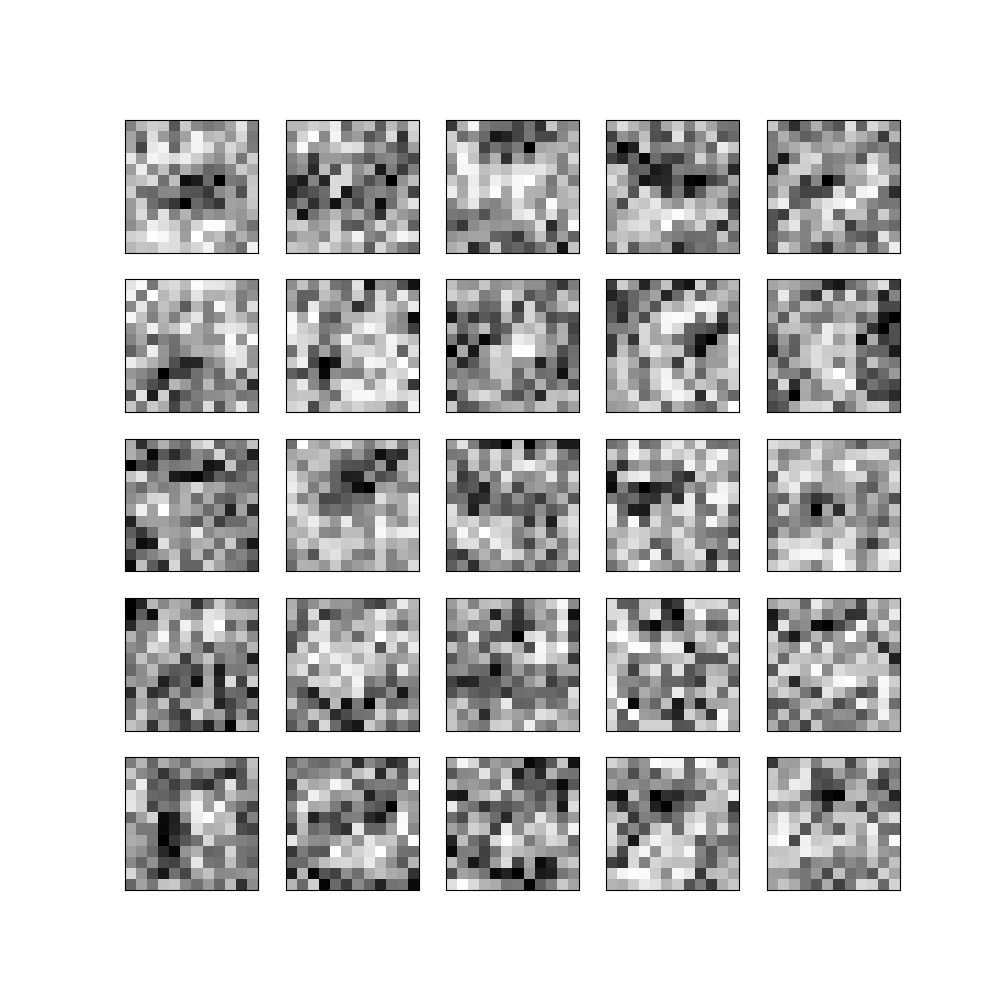

In [9]:
# Visualise the filters in the first convolutional layer
with sess.as_default():
    W = W_conv1.eval()
    fig = plt.figure()
    for i in range(25):
        ax = fig.add_subplot(5, 5, i + 1)
        ax.set_xticks(())
        ax.set_yticks(())
        filter1 = W[:,:,:,i]
        ax.imshow(filter1.reshape(12,12), cmap='Greys_r')  


#### Identifying image patches that activate the filters

For this part you'll find the 12 patches in the test-set that activate each of the first 5 filters that maximise the activation for that filter.

<IPython.core.display.Javascript object>


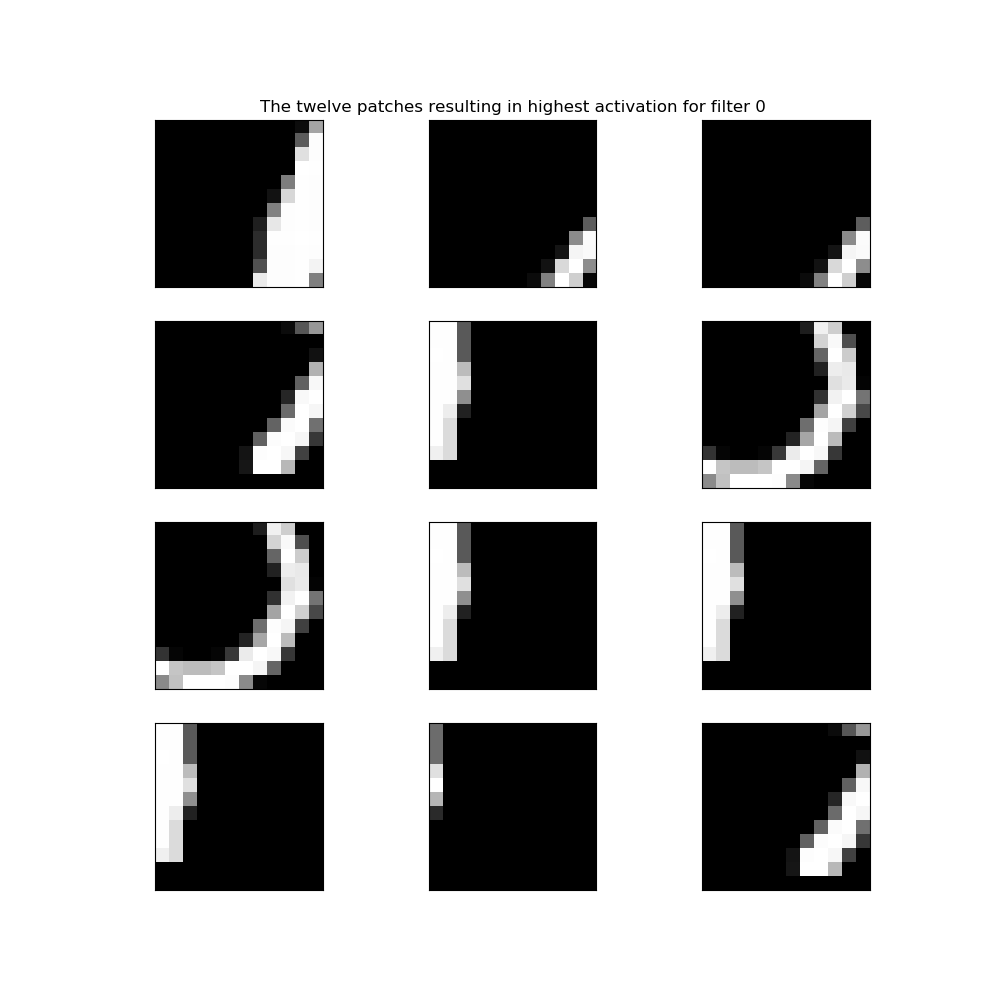

<IPython.core.display.Javascript object>


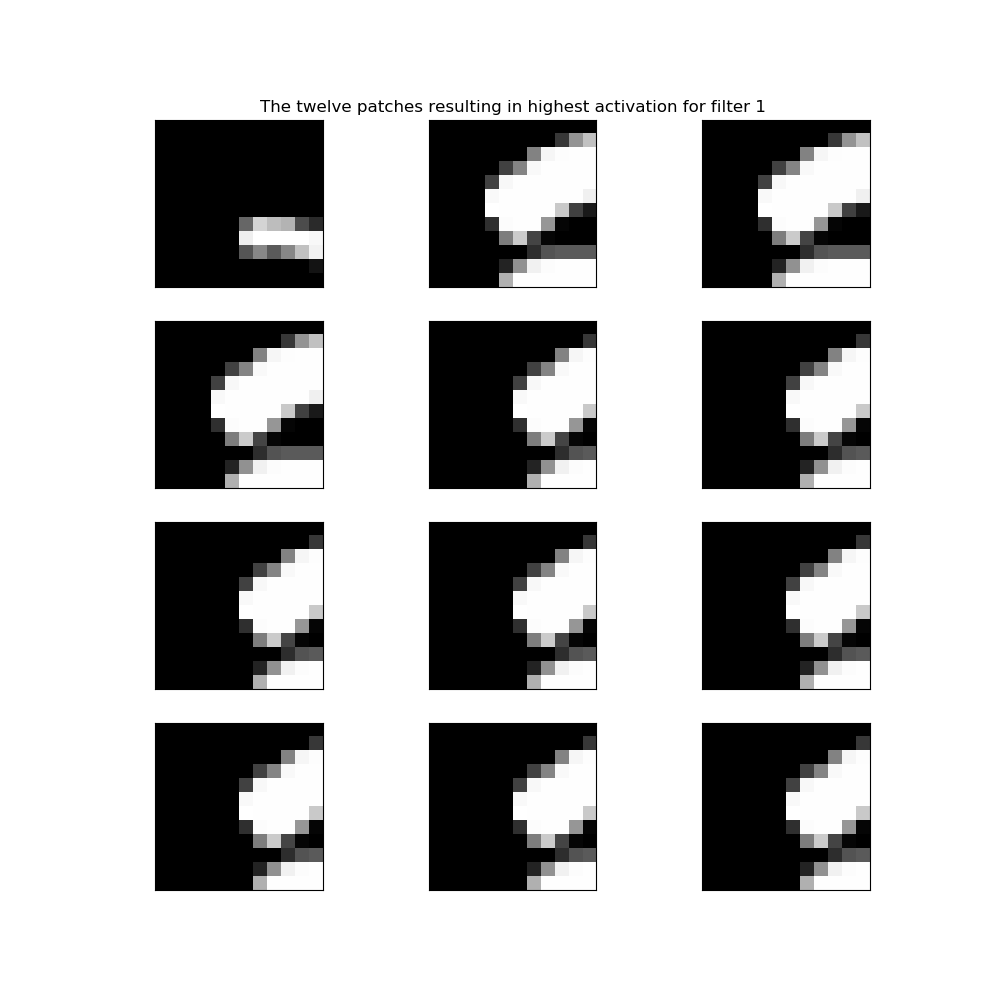

<IPython.core.display.Javascript object>


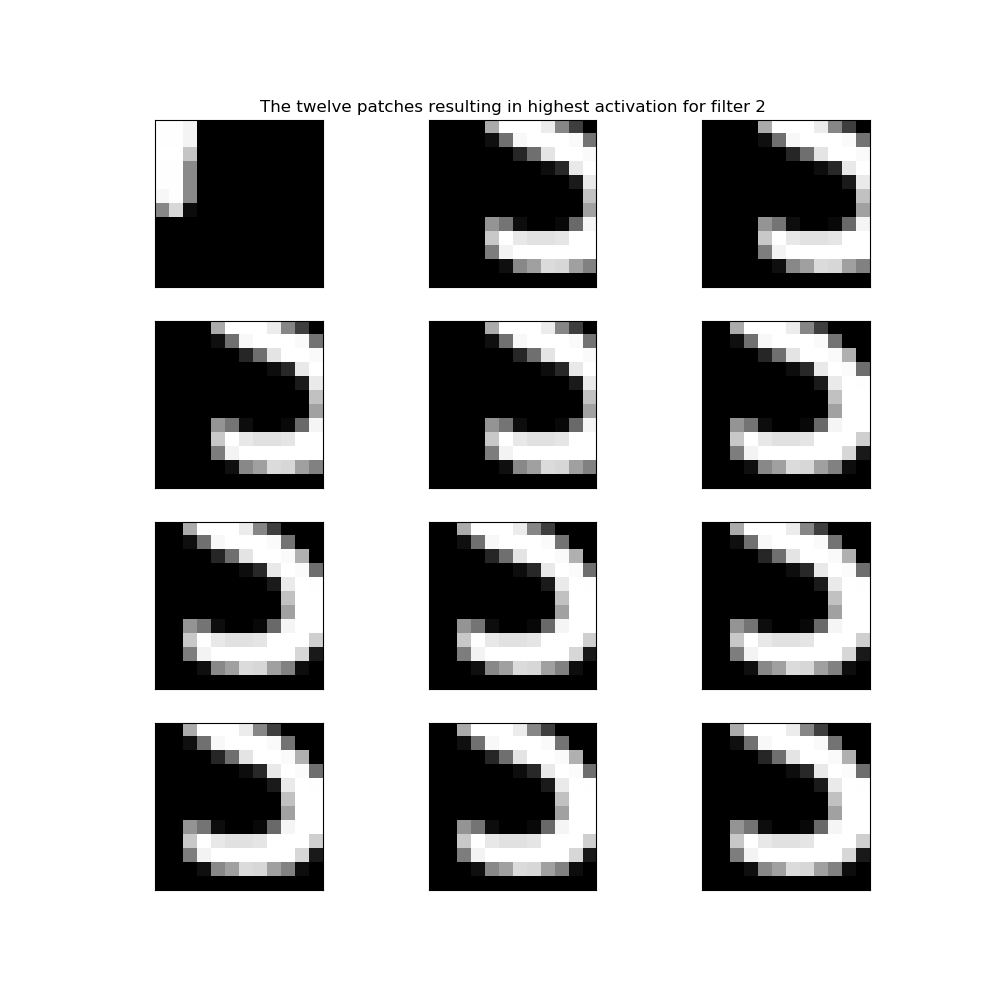

<IPython.core.display.Javascript object>


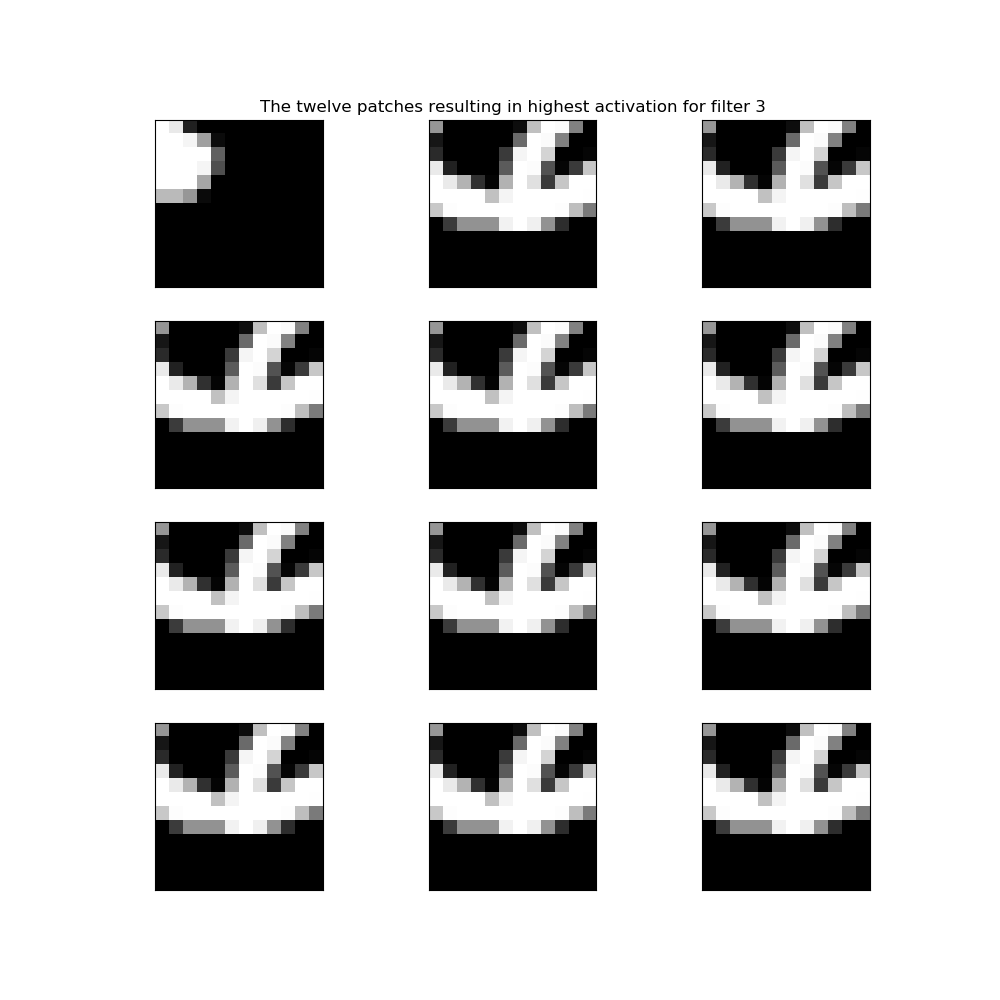

<IPython.core.display.Javascript object>


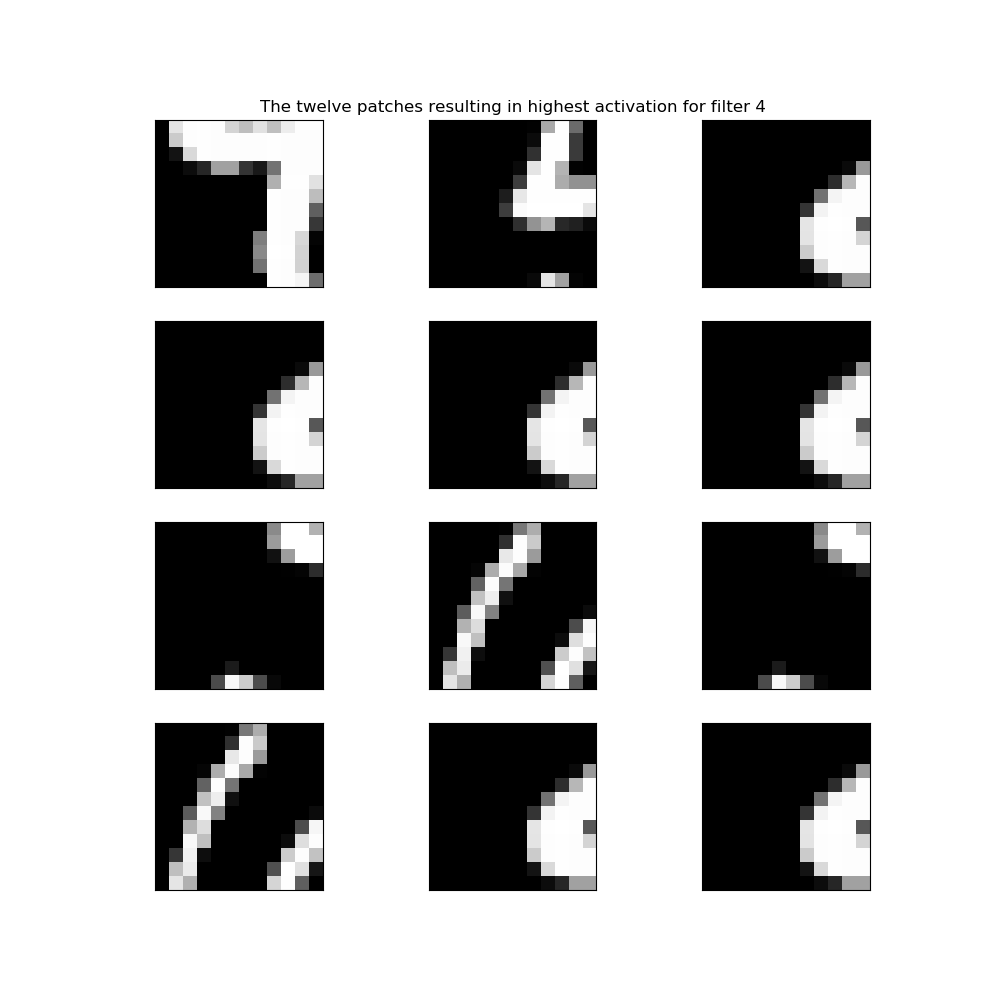

In [10]:
H = sess.run(h_conv1, feed_dict={x: mnist.test.images})
reshaped_images = mnist.test.images.reshape(-1, 28, 28)

# Add code to visualise patches in the test set that find the most result in 
# the highest activations for filters 0, ... 4
for filter_num in range(5):
    sort_indices = np.argsort(H[:,:,:,filter_num], axis=None)
    unraveled_indices = np.unravel_index(sort_indices[:12], H.shape)
    fig = plt.figure()
    plt.title('The twelve patches resulting in highest activation for filter {}'.format(filter_num))
    plt.axis('off')
    for i in range(12):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_xticks(())
        ax.set_yticks(())
        img_nos, xs, ys, filter_nos = unraveled_indices
        img_no = img_nos[i]
        left = xs[i] * 2
        right = left + 11
        top = ys[i] * 2
        bottom = top + 11
        ax.imshow(reshaped_images[img_no][left:right+1,top:bottom+1], cmap='Greys_r')